<a href="https://colab.research.google.com/github/nataliasbsg/Dataset_animales/blob/main/Analisis_Resultados_Reales_SinEjecutar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# LIBRERIAS
# Importación de archivos desde drive
from google.colab import drive

# Tratamiento de imagenes
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import zipfile
from PIL import Image

# Librerias para la red
import tensorflow as tf
import tensorflow_hub as hub

# Trabajar con url
import requests
from io import BytesIO

# Lectura de imágenes desde GitHub
Se accede a las imagenes contenidas en GitHub (https://github.com/nataliasbsg/Dataset_animales). En este enlace se pueden encontrar 5 carpetas:
1. BD_Familia: todas las imagenes con las cuales se ha entrenado la red, Clasificadas en categrías y subcategorías.
2.BD_Familia_Test: imágenes que nunca entraron en el entrenamiento de la red y también clasificadas. Hay 100 fotos de cada especie y su objetivo es testear la red-
3.Modelos_Redes_Entrenados: son los modelos de las redes de familias y especies entrenados. El usuario no tiene necesidad de realizar nada con ellos, las redes los invocan cuando los requieren automáticamente.
4. RealTest: imágenes de animales sin clasificar. Estas imágenes son para mostrar una aplicación más real de las redes y es el usuario el que determina lo que ha acertado la red. Estas imágenes se han sacado aleatorimente de BD_Familia_Test. 
5. RealTest_little: versión anterior con menos cantidad de imágenes. Estas imágenes se han sacado aleatorimente de BD_Familia_Test. 
6. src: Carpeta que contiene los código que implementan las redes.

En este caso se van a utilizar las imágenes de BD_Familia_Test y están clasificadas en tres niveles de carpetas:
1. Base de Datos general. Una sola carpeta que contiene todas las familias de animales que se quieren estudiar. Por ejemplo: "Base de datos de animales".
2. Conjunto de carpetas de familias de animales que a su vez contienen las carpetas de especies animales de la misma familia (categories). Por ejemplo:  dentro de "Base de datos de animales" encontraríamos "Cánidos" y "Felinos".
3. Conjunto de carpetas de especies animales (subcategories). Contienen las imagenes con las que se va a trabajar. Por ejemplo: dentro de "Felinos" encontraríamos "Linces" y "Gatos".


Se estudiará la pertenencia a las familias de cada imagen y para ello se numerará la cantidad de imágenes de cada familia (no de cada especie) y se hará una copia de las imágenes clasificadas en la máquina virtual en la carpeta tmp (/tmp).

En este caso las familias y las especies de cada una son las siguientes:
0. Cánidos: zorros.
1. Cérvidos: ciervos y gamos.
2. Felinos: gatos y linces.
3. Herpéstidos: meloncillos.
4. Lepóridos: conejos y liebres.
5. Mustélidos: tejones.
6. Suidos: jabalíes.
7. Vivérridos: ginetas.

In [ ]:
!wget --no-check-certificate \
    "https://github.com/nataliasbsg/Dataset_animales/archive/refs/heads/master.zip" \
    -O "/tmp/Dataset_animales.zip"


zip_ref = zipfile.ZipFile('/tmp/Dataset_animales.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
# Carpeta raiz
dir = '/tmp/Dataset_animales-main'

# Carpeta donde se almacenan los modelos de redes entrenados
dir_modelos = dir + '/Modelos_Redes_Entrenados'
# Se cargan los modelos de las redes
modelo = tf.keras.models.load_model(dir_modelos + '/clasificador_animales.h5',custom_objects={'KerasLayer':hub.KerasLayer})
modelo_cervidos = tf.keras.models.load_model(dir_modelos + '/clasificador_cérvidos.h5',custom_objects={'KerasLayer':hub.KerasLayer})
modelo_felinos = tf.keras.models.load_model(dir_modelos + '/clasificador_felinos.h5',custom_objects={'KerasLayer':hub.KerasLayer})
modelo_leporidos = tf.keras.models.load_model(dir_modelos + '/clasificador_lepóridos.h5',custom_objects={'KerasLayer':hub.KerasLayer})

dir_bd = dir + '/RealTest_little'

In [ ]:
# Se guardan en categories las familias a clasificas y en subcategorias las especies
categories = ['Canidos', 'Cervidos', 'Felinos', 'Herpestidos', 'Leporidos', 'Mustelidos', 'Suidos', 'Viverridos']
subcategories = [['Zorro'], ['Ciervo', 'Gamo'], ['Gato montes', 'Lince iberico'], ['Meloncillo'], ['Conejo', 'Liebre'], ['Tejon'], ['Jabali'], ['Gineta']]
# Se crean carpetas y subcarpetas para la clasificacion de imagenes
for i, categorie in enumerate(categories):
  for subcategorie in subcategories[i]:
    carpeta_destino = dir + '/animales_clasificados/{}/{}'.format(categorie, subcategorie)
    if not os.path.exists(carpeta_destino):
       os.makedirs(carpeta_destino)


In [ ]:
# Se hace un diccionario de modelos para acceder a ellos facilmente
dict_modelos = {
    "Cervidos": modelo_cervidos,
    "Felinos": modelo_felinos,
    "Leporidos": modelo_leporidos
}

In [ ]:
# Se crea una clase para sacar información de la imagenes facilmente
class ImagePrediction():
  """ 
  Clase para predecir la especie animal de la imagen dada.

  Attributes
  -----------
  img_original: ndarray
    Imagen leída.
  img: ndarray
    Imagen adaptada para trabajar con ella.
  categorie:  int
    Categoria de la imagen.
  subcategorie:  int    
    Subcategoria de la imagen.
  categorie_real_name: str
    Nombre de categoria de la imagen.
  subcategorie_real_name: str
    Nombre de categoria de la imagen.
  categorie_predict_probability:  array[float]
    Probabilidad de la categoria de la imagen predicha.
  subcategorie_predict_probability:  array[float]
    Probabilidad de la subcategoria de la imagen predicha.
  categorie_predict:  int
    Categoria de la imagen predicha.
  subcategorie_predict:  int
    Subcategoria de la imagen predicha.
  categorie_predict_name: str
    Categoria de la imagen predicha.
  subcategorie_predict_name: str
    Subcategoria de la imagen predicha.
  """
  
  def __init__(self, dir_img):
    self.img_original = cv2.imread(dir_img)
    self.img = np.array(self.img_original).astype(float)/255
    self.img = cv2.resize(self.img, (224,224))
    self.img = np.array(self.img).astype(float)
    self.name = os.path.basename(dir_img)
    self.predict()
	
  def predict(self):
    self.categorie_predict_probability = modelo.predict(self.img.reshape(-1, 224, 224, 3))[0]
    self.categorie_predict = np.argmax(self.categorie_predict_probability)
    self.categorie_predict_name = categories[self.categorie_predict]
    
    if categories[self.categorie_predict] in dict_modelos:
      modelo_subcategorie = dict_modelos[categories[self.categorie_predict]]
      self.subcategorie_predict_probability = modelo_subcategorie.predict(self.img.reshape(-1, 224, 224, 3))[0]
      self.subcategorie_predict = np.argmax(self.subcategorie_predict_probability)
      self.subcategorie_predict_name = subcategories[self.categorie_predict][self.subcategorie_predict]

    else:
      self.subcategorie_predict_probability = [1]
      self.subcategorie_predict = 0
      self.subcategorie_predict_name = subcategories[self.categorie_predict][self.subcategorie_predict]

In [ ]:
num_img = len(os.listdir(dir_bd))
columnas = 4
filas = int(num_img / 4)+1

In [ ]:
def graficar_imagen(img_graf: ImagePrediction):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  img = img_graf.img[:,:,[2,1,0]]
  plt.imshow(img)

  plt.xlabel("Familia: {} ({:2.0f}%) \n Especie: {} ({:2.0f}%)".format(img_graf.categorie_predict_name, 
                                           100*np.max(img_graf.categorie_predict_probability),
                                           img_graf.subcategorie_predict_name,
                                           100*np.max(img_graf.subcategorie_predict_probability)),fontsize=20)

# Visualización de imágenes categorizadas
Se van a mostrar las imágenes con las predicciones con la predicción de la familia, la especie y el porcentaje de seguridad respecto a dichas predicciones.

In [ ]:
# Se predice la clase de cada imagen con la clase ImagePrediction y se clasifican en carpetas y subcarpetas
plt.figure(figsize=(10*columnas, 10*filas))
for i, img in  enumerate(os.listdir(dir_bd)):
    img2 = ImagePrediction(dir_bd + "/" + img)
    img_category = img2.categorie_predict_name
    img_subcategory = img2.subcategorie_predict_name
    img_name = img2.name
    cv2.imwrite(dir + '/animales_clasificados/{}/{}/{}'.format(img_category, img_subcategory, img_name), img2.img_original)
    plt.subplot(filas, columnas, i+1)
    graficar_imagen(img_graf= img2)

In [ ]:
for i, categorie in enumerate(categories):
    for subcategorie in subcategories[i]:
      n_img = len(os.listdir(dir + '/animales_clasificados/{}/{}'.format(categorie, subcategorie)))
      print( f'Se han clasificado como {subcategorie:15} {n_img:3} imágenes') 

# ¡Pruébalo tú mismo con la imagen que quieras!
Busca el animal que quieras en internet y a la imagen deseada le das click derecho y en el desplegable selecciona "Copiar dirreción de imagen". Esa url pégala abajo y nuestra red intentará predecir qué especie es.

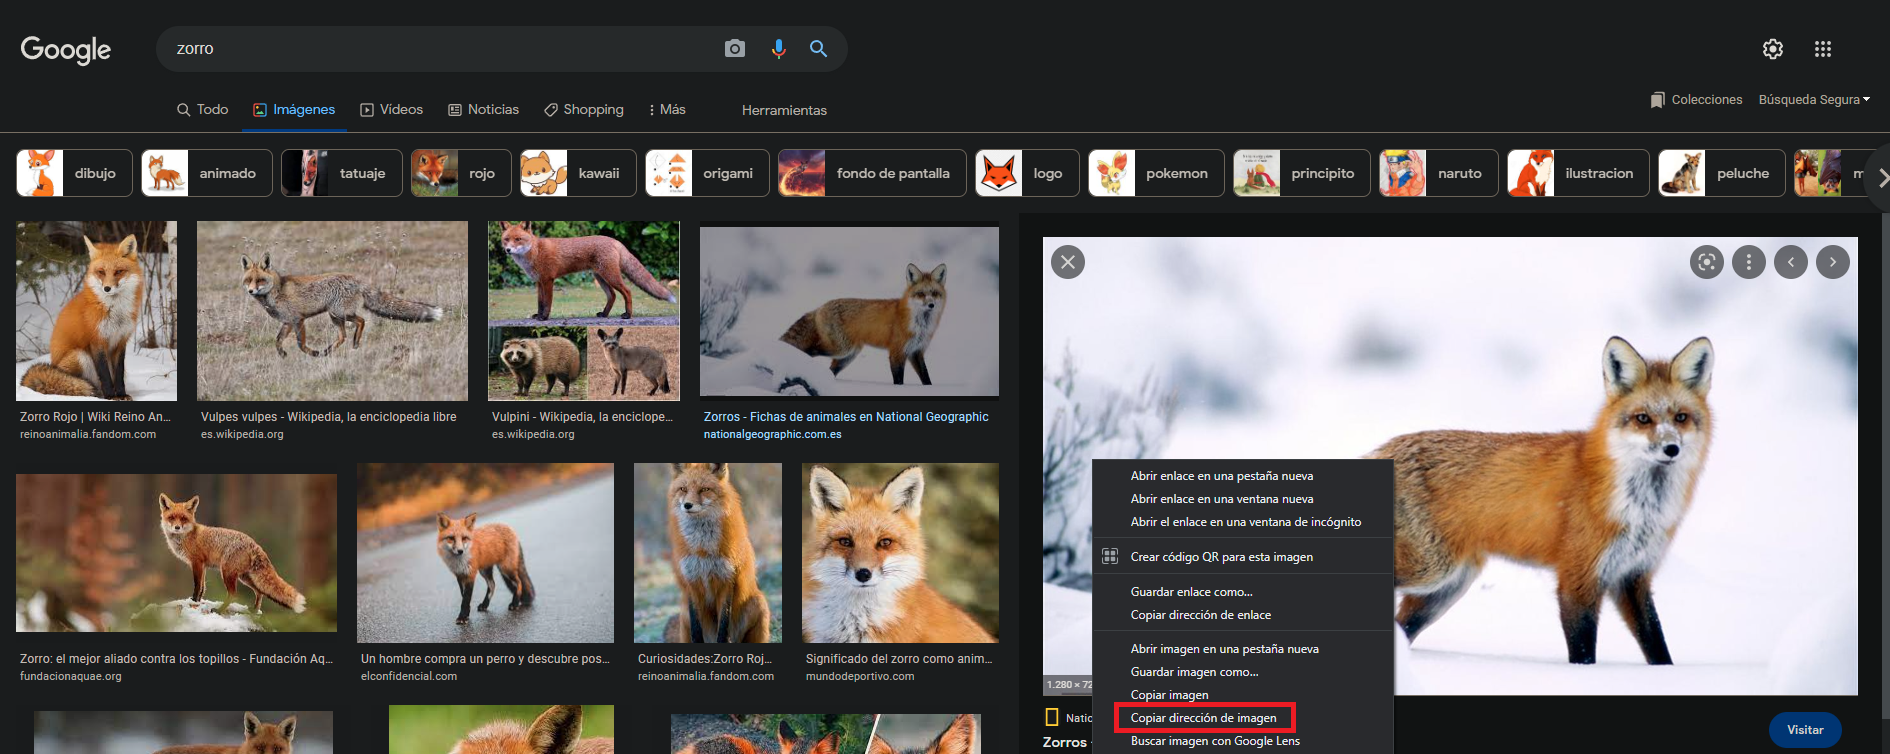

In [ ]:
class ImageCategory():
  """ 
  Clase para predecir la especie animal de la imagen dada.

  Attributes
  -----------
  img_original: ndarray
    Imagen leída.
  img: ndarray
    Imagen adaptada para trabajar con ella.
  categorie:  int
    Categoria de la imagen.
  subcategorie:  int    
    Subcategoria de la imagen.
  categorie_real_name: str
    Nombre de categoria de la imagen.
  subcategorie_real_name: str
    Nombre de categoria de la imagen.
  categorie_predict_probability:  array[float]
    Probabilidad de la categoria de la imagen predicha.
  subcategorie_predict_probability:  array[float]
    Probabilidad de la subcategoria de la imagen predicha.
  categorie_predict:  int
    Categoria de la imagen predicha.
  subcategorie_predict:  int
    Subcategoria de la imagen predicha.
  categorie_predict_name: str
    Categoria de la imagen predicha.
  subcategorie_predict_name: str
    Subcategoria de la imagen predicha.
  """
  
  def __init__(self, dir_img):
    self.respuesta = requests.get(url)
    self.img_original = Image.open(BytesIO(self.respuesta.content))
    self.img = np.array(self.img_original).astype(float)/255
    self.img = cv2.resize(self.img, (224,224))
    self.img = np.array(self.img).astype(float)
    self.name = os.path.basename(dir_img)
    self.predict()
	
  def predict(self):
    self.categorie_predict_probability = modelo.predict(self.img.reshape(-1, 224, 224, 3))[0]
    self.categorie_predict = np.argmax(self.categorie_predict_probability)
    self.categorie_predict_name = categories[self.categorie_predict]
    
    if categories[self.categorie_predict] in dict_modelos:
      modelo_subcategorie = dict_modelos[categories[self.categorie_predict]]
      self.subcategorie_predict_probability = modelo_subcategorie.predict(self.img.reshape(-1, 224, 224, 3))[0]
      self.subcategorie_predict = np.argmax(self.subcategorie_predict_probability)
      self.subcategorie_predict_name = subcategories[self.categorie_predict][self.subcategorie_predict]

    else:
      self.subcategorie_predict_probability = [1]
      self.subcategorie_predict = 0
      self.subcategorie_predict_name = subcategories[self.categorie_predict][self.subcategorie_predict]

In [ ]:
def graficar_imagen_url(img_graf: ImagePrediction):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  img = img_graf.img[:,:,[0,1,2]]
  plt.imshow(img)

  plt.xlabel("Familia: {} ({:2.0f}%) \n Especie: {} ({:2.0f}%)".format(img_graf.categorie_predict_name, 
                                           100*np.max(img_graf.categorie_predict_probability),
                                           img_graf.subcategorie_predict_name,
                                           100*np.max(img_graf.subcategorie_predict_probability)),fontsize=20)

In [ ]:
def categorizar_imagen_url(url: str):
  plt.figure(figsize=(10*columnas, 10*filas))
  img3 = ImageCategory(url)
  img_category = img3.categorie_predict_name
  img_subcategory = img3.subcategorie_predict_name
  img_name = img3.name
  plt.subplot(filas, columnas, i+1)
  graficar_imagen_url(img_graf= img3)

In [ ]:
#Categorizar una imagen de internet

#EJEMPLOS

# url = 'https://wwfes.awsassets.panda.org/img/original/cachorros_de_odrina_16__antonio_liebana.jpg'
# url = 'https://www.ecoticias.com/wp-content/uploads/2022/01/GRKG_AV27_Huella_foto2.jpg'
url = 'https://img.freepik.com/foto-gratis/ciervo-rojo-habitat-natural-rutina-ciervos-fauna-europea_475641-941.jpg?size=626&ext=jpg&ga=GA1.2.1518270500.1634256000'
# url ='https://elguadarramista.files.wordpress.com/2016/07/7.jpg?w=1400'
# url ='https://as01.epimg.net/diarioas/imagenes/2022/04/20/actualidad/1650466413_240889_1650466661_noticia_normal_recorte1.jpg'
# url = 'https://www.fundacionaquae.org/wp-content/uploads/2021/10/meloncillo-clip-natura-1024x576.jpg'
categorizar_imagen_url(url)

#Introduce aquí tu url

In [ ]:
# Introduce la url que desees sin comillas
# Ejemplo:
# https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ7jF9HT3bF-IrDPr2SG1YcGnzz0L2WNOlHdw&usqp=CAU
url=input()
categorizar_imagen_url(url)

#Clasifica las imágenes que tengas en Drive

Para este opción colab te pedirá permisos de tu cuenta, pero tan solo tú podrás tabajar con tu cuenta y visualizar esos resultados.

En este caso se dan dos opciones:
1. Seleccionar la imagen directamente y ver la predicción por pantalla.
2. Seleccionar una carpeta de archivos con varios animales. En esta opción se crearán carpetas con los animales clasificados en la carpeta de archivos temporales de google colaboratory, en el caso de desear esos archivos en tu cuenta de drive, tan solo sería selccionar la carpeta de destino.

Veámoslo paso a paso.

Comenzamos pidiendo los permisos para acceder a tu cuenta de Drive.

In [ ]:
# Se accede a drive y se piden los permisos al usuario para trabajar en su cuenta
from google.colab import drive
drive.mount('/content/drive')

# Selección de una sola imagen

Se ha de copiar la ruta donde se almacena la imagen.

Ejemplo:

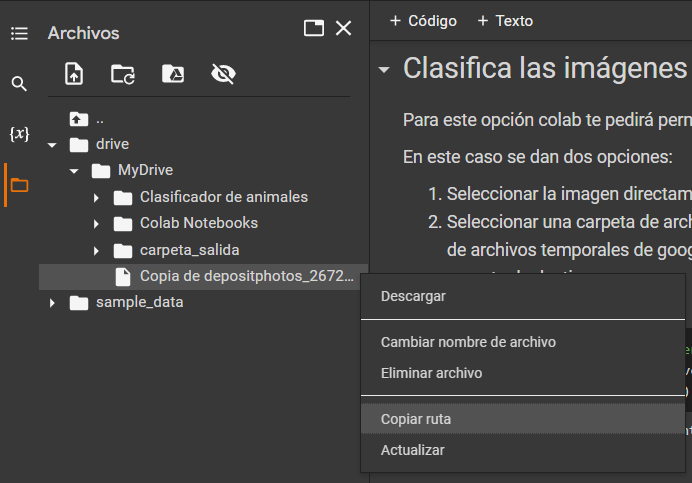

In [ ]:
#Introduce la dirección de la imagen
# Nota: poner las instrucciones y direcciones sin comillas
img_user = input()

In [ ]:
# En este caso se guardará la imagen clasificada en archivos temporales
dir = '/tmp/Dataset_animales-main'

In [ ]:
# Se guardan en categories las familias a clasificas y en subcategorias las especies
categories = ['Canidos', 'Cervidos', 'Felinos', 'Herpestidos', 'Leporidos', 'Mustelidos', 'Suidos', 'Viverridos']
subcategories = [['Zorro'], ['Ciervo', 'Gamo'], ['Gato montes', 'Lince iberico'], ['Meloncillo'], ['Conejo', 'Liebre'], ['Tejon'], ['Jabali'], ['Gineta']]
# Se crean carpetas y subcarpetas para la clasificacion de imagenes
for i, categorie in enumerate(categories):
  for subcategorie in subcategories[i]:
    carpeta_destino = dir + '/animales_clasificados/{}/{}'.format(categorie, subcategorie)
    if not os.path.exists(carpeta_destino):
       os.makedirs(carpeta_destino)

In [ ]:
plt.figure(figsize=(10*columnas, 10*filas))
img_user = ImagePrediction(img_user)
img_category = img_user.categorie_predict_name
img_subcategory = img2.subcategorie_predict_name
img_name = img_user.name
cv2.imwrite(dir + '/animales_clasificados/{}/{}/{}'.format(img_category, img_subcategory, img_name), img_user.img_original)
plt.subplot(filas, columnas, i+1)
graficar_imagen(img_graf= img_user)

# Selección de una carpeta

Se ha de copiar la ruta donde se almacena la carpeta con las imágenes.

Es muy importante que en esta carpeta existan tan solo imágenes y no archivos con otros formatos.

In [ ]:
#Introduce la dirección de la carpeta con las imagenes (exclusivamente imagenes)
# Nota: poner las instrucciones y direcciones sin comillas
dir_file = input()

In [ ]:
# En este apartado el usuario decide donde almacenar la carpeta creada
# Si el usuario escribe A le pedirá la ruta donde quiere almacenarlo
# Si el usuario escribe cualquier otro comando la carpeta creada se almacenará en archivos temporales
# Nota: poner las instrucciones y direcciones sin comillas

opcion=input()
if opcion=='A':
  print ('************************************************')
  print ('Introduce la dirección donde quieres almacenarlo')
  print ('************************************************')
  dir_save = input()
else:
  dir_save = '/tmp/Dataset_animales-main'

In [ ]:
# Se guardan en categories las familias a clasificas y en subcategorias las especies
categories = ['Canidos', 'Cervidos', 'Felinos', 'Herpestidos', 'Leporidos', 'Mustelidos', 'Suidos', 'Viverridos']
subcategories = [['Zorro'], ['Ciervo', 'Gamo'], ['Gato montes', 'Lince iberico'], ['Meloncillo'], ['Conejo', 'Liebre'], ['Tejon'], ['Jabali'], ['Gineta']]
# Se crean carpetas y subcarpetas para la clasificacion de imagenes
for i, categorie in enumerate(categories):
  for subcategorie in subcategories[i]:
    carpeta_destino = dir + '/animales_clasificados/{}/{}'.format(categorie, subcategorie)
    if not os.path.exists(carpeta_destino):
       os.makedirs(carpeta_destino)

In [ ]:
# Se predice la clase de cada imagen con la clase ImagePrediction y se clasifican en carpetas y subcarpetas
plt.figure(figsize=(10*columnas, 10*filas))
for i, img in  enumerate(os.listdir(dir_file)):
    img2 = ImagePrediction(dir_file + "/" + img)
    img_category = img2.categorie_predict_name
    img_subcategory = img2.subcategorie_predict_name
    img_name = img2.name
    cv2.imwrite(dir_save + '/animales_clasificados/{}/{}/{}'.format(img_category, img_subcategory, img_name), img2.img_original)
    plt.subplot(filas, columnas, i+1)
    graficar_imagen(img_graf= img2)